![Landsat8](./images/nasa_landsat8.jpg "Landsat8")

# Data Ingestion - Intake

---

## Overview

In the last notebook, you learned how to efficiently load data from the Microsoft Planetary Computer platform. If that approach works for you, please proceed to a workflow example. In this notebook we will demonstrate common alternative approaches and techniques for general data access, centered around [Intake](https://intake.readthedocs.io).

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
        A great way to contribute to this cookbook is to create a notebook that focuses on data access from a specific provider.
</div>

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Landsat](./0.0_Intro_Landsat.ipynb) | Necessary | Background |
| [Data Ingestion - Planetary Computer](1.0_Data_Ingestion-Planetary_Computer.ipynb) | Helpful | |
| [Pandas Cookbook](https://foundations.projectpythia.org/core/pandas.html) | Helpful |  |
| [xarray Cookbook](https://foundations.projectpythia.org/core/xarray.html) | Necessary |  |
| [Intake Quickstart](https://intake.readthedocs.io/en/latest/index.html) | Helpful |  |
|[Intake Cookbook](https://projectpythia.org/intake-cookbook/README.html)| Necessary | |

- **Time to learn**: 20 minutes

---

## Imports

In [1]:
import intake
import hvplot.xarray
import planetary_computer

import warnings
warnings.simplefilter('ignore', FutureWarning) # Ignore warning about the format of epsg codes

To get started, we need to provide a STAC URL (or any other data source URL) to intake, and we can ask intake to recommend some suitable datatypes.

In [2]:
url = "https://planetarycomputer.microsoft.com/api/stac/v1"
data_types = intake.readers.datatypes.recommend(url)
print(data_types)

[<class 'intake.readers.datatypes.JSONFile'>, <class 'intake.readers.datatypes.STACJSON'>, <class 'intake.readers.datatypes.Handle'>, <class 'intake.readers.datatypes.TiledService'>, <class 'intake.readers.datatypes.CatalogAPI'>]


We will use STACJSON to read the URL.

In [3]:
data_type = intake.datatypes.STACJSON(url)
data_type

STACJSON, {'url': 'https://planetarycomputer.microsoft.com/api/stac/v1', 'storage_options': None, 'metadata': {}}

Similarly, we can check out the possible readers to use with the STACJSON datatype.

In [4]:
readers = data_type.possible_readers
print(readers)

{'importable': [<class 'intake.readers.catalogs.StacCatalogReader'>, <class 'intake.readers.catalogs.StackBands'>, <class 'intake.readers.catalogs.StacSearch'>, <class 'intake.readers.readers.DaskJSON'>, <class 'intake.readers.readers.FileExistsReader'>, <class 'intake.readers.readers.FileByteReader'>, <class 'intake.readers.readers.FileTextReader'>], 'not_importable': [<class 'intake.readers.readers.PolarsJSON'>, <class 'intake.readers.readers.AwkwardJSON'>, <class 'intake.readers.readers.DuckJSON'>, <class 'intake.readers.readers.RayJSON'>, <class 'intake.readers.readers.RayBinary'>]}


The StacCatalogReader is probably the most suitable for our use case. We can use it to read the STAC catalog and explore the available contents.

In [5]:
reader = intake.catalogs.StacCatalogReader(
    data_type, signer=planetary_computer.sign_inplace
)
reader

StacCatalogReader reader producing intake.readers.entry:Catalog

We can read the catalog and see what's available:

In [6]:
stac_cat = reader.read()

In [7]:
metadata = {}
for data_description in stac_cat.data.values():
    data = data_description.kwargs["data"]
    metadata[data["id"]] = data["description"]
list(metadata.keys())

['daymet-annual-pr',
 'daymet-daily-hi',
 '3dep-seamless',
 '3dep-lidar-dsm',
 'fia',
 'sentinel-1-rtc',
 'gridmet',
 'daymet-annual-na',
 'daymet-monthly-na',
 'daymet-annual-hi',
 'daymet-monthly-hi',
 'daymet-monthly-pr',
 'gnatsgo-tables',
 'hgb',
 'cop-dem-glo-30',
 'cop-dem-glo-90',
 'goes-cmi',
 'terraclimate',
 'nasa-nex-gddp-cmip6',
 'gpm-imerg-hhr',
 'gnatsgo-rasters',
 '3dep-lidar-hag',
 'io-lulc-annual-v02',
 '3dep-lidar-intensity',
 '3dep-lidar-pointsourceid',
 'mtbs',
 'noaa-c-cap',
 '3dep-lidar-copc',
 'modis-64A1-061',
 'alos-fnf-mosaic',
 '3dep-lidar-returns',
 'mobi',
 'landsat-c2-l2',
 'era5-pds',
 'chloris-biomass',
 'kaza-hydroforecast',
 'planet-nicfi-analytic',
 'modis-17A2H-061',
 'modis-11A2-061',
 'daymet-daily-pr',
 '3dep-lidar-dtm-native',
 '3dep-lidar-classification',
 '3dep-lidar-dtm',
 'gap',
 'modis-17A2HGF-061',
 'planet-nicfi-visual',
 'gbif',
 'modis-17A3HGF-061',
 'modis-09A1-061',
 'alos-dem',
 'alos-palsar-mosaic',
 'deltares-water-availability',
 

We can print the description of the desired IDs.

In [8]:
print("1:", metadata["landsat-c2-l1"])
print("2:", metadata["landsat-c2-l2"])

1: Landsat Collection 2 Level-1 data, consisting of quantized and calibrated scaled Digital Numbers (DN) representing the multispectral image data. These [Level-1](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data) data can be [rescaled](https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product) to top of atmosphere (TOA) reflectance and/or radiance. Thermal band data can be rescaled to TOA brightness temperature.

This dataset represents the global archive of Level-1 data from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2) acquired by the [Multispectral Scanner System](https://landsat.gsfc.nasa.gov/multispectral-scanner-system/) onboard Landsat 1 through Landsat 5 from July 7, 1972 to January 7, 2013. Images are stored in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

2: Landsat Collection 2 Level-2 [Science Products](https://www.usgs.gov/landsat-missions/landsat-collection-2-leve

Specifically, we want landsat-c2-l2.

In [9]:
landsat_reader = stac_cat["landsat-c2-l2"]

We can see the metadata below.

In [10]:
landsat_reader.read().metadata

{'type': 'Collection',
 'id': 'landsat-c2-l2',
 'stac_version': '1.0.0',
 'description': 'Landsat Collection 2 Level-2 [Science Products](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products), consisting of atmospherically corrected [surface reflectance](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance) and [surface temperature](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature) image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present.\n\nThis dataset represents the global archive of Level-2 data from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2) acquired by the [Thematic Mapper](https://landsat.gsfc.nasa.gov/thematic-mapper/) onboard Landsat 4 and 5, the [Enhanced Thematic Mapper](https://landsat.gsfc.nasa.gov/the-enhanced-thematic-mapper-plus-etm/) onboard Landsat 7, and the [Operatational Land Imager](ht

We can get a preview of the dataset by looking at the thumbnail.

In [11]:
# data as array
landsat_reader["thumbnail"].read()

BokehModel(combine_events=True, render_bundle={'docs_json': {'2919f699-f842-4f2a-b30e-79e5fac128d6': {'version…

In [12]:
# render with panel
landsat_reader["thumbnail"].to_reader("panel")

PanelImageViewer reader producing panel.pane:Image

If that's desired, we can move on to get the items in the catalog.


In [13]:
landsat_items = landsat_reader["geoparquet-items"]
landsat_items

DaskGeoParquet reader producing dask_geopandas.core:GeoDataFrame

In [14]:
# note `output_instance`: this is because .tail() makes a pandas from a dask dataframe. GeoDataFrameToSTACCatalog
# works specifically with geopandas only
cat = landsat_items.tail(output_instance="geopandas:GeoDataFrame").GeoDataFrameToSTACCatalog.read()

/Users/ahuang/miniconda3/envs/landsat-ml-cookbook/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()


In [15]:
# this is an "item collection"; each item is a set of assets (many levels here)
cat

Catalog
 named datasets: ['LC09_L2SP_105013_20240301_02_T1', 'LC09_L2SP_105014_20240301_02_T1', 'LC09_L2SP_105015_20240301_02_T1', 'LC09_L2SP_105016_20240301_02_T2', 'LC09_L2SP_105017_20240301_02_T2']

Repeat the process aforementioned.

In [16]:
item_key = list(cat.entries.keys())[0]
subcat = cat[item_key].read()
subcat

Catalog
 named datasets: ['ang', 'atran', 'blue', 'cdist', 'coastal', 'drad', 'emis', 'emsd', 'green', 'lwir11', 'mtl.json', 'mtl.txt', 'mtl.xml', 'nir08', 'qa', 'qa_aerosol', 'qa_pixel', 'qa_radsat', 'red', 'rendered_preview', 'swir16', 'swir22', 'tilejson', 'trad', 'urad']

In [17]:
# single image in one band
subcat.red.read()

[<xarray.DataArray (band: 1, y: 8181, x: 8121)>
 [66437901 values with dtype=uint16]
 Coordinates:
   * band         (band) int64 1
   * x            (x) float64 4.455e+05 4.455e+05 ... 6.891e+05 6.891e+05
   * y            (y) float64 6.939e+06 6.939e+06 ... 6.693e+06 6.693e+06
     spatial_ref  int64 0
 Attributes:
     AREA_OR_POINT:  Point
     _FillValue:     0
     scale_factor:   1.0
     add_offset:     0.0]

In [18]:
# unfortunately, the "signer" didn't make it through
catbands = cat[item_key].to_reader(reader="StackBands", bands=["red", "green", "blue"], signer=planetary_computer.sign_inplace)

Then, we can load the actual assets.

In [19]:
# multiband image. Unfortunately, the value of the "band" variable in each input is 1, not the real
# value; they could be relabelled here
data = catbands.read(dim="band")
data

<xarray.DataArray (band: 3, y: 8181, x: 8121)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1 1 1
  * x            (x) float64 4.455e+05 4.455e+05 ... 6.891e+05 6.891e+05
  * y            (y) float64 6.939e+06 6.939e+06 ... 6.693e+06 6.693e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

Now, we can plot the true color imagery with the extracted bands.

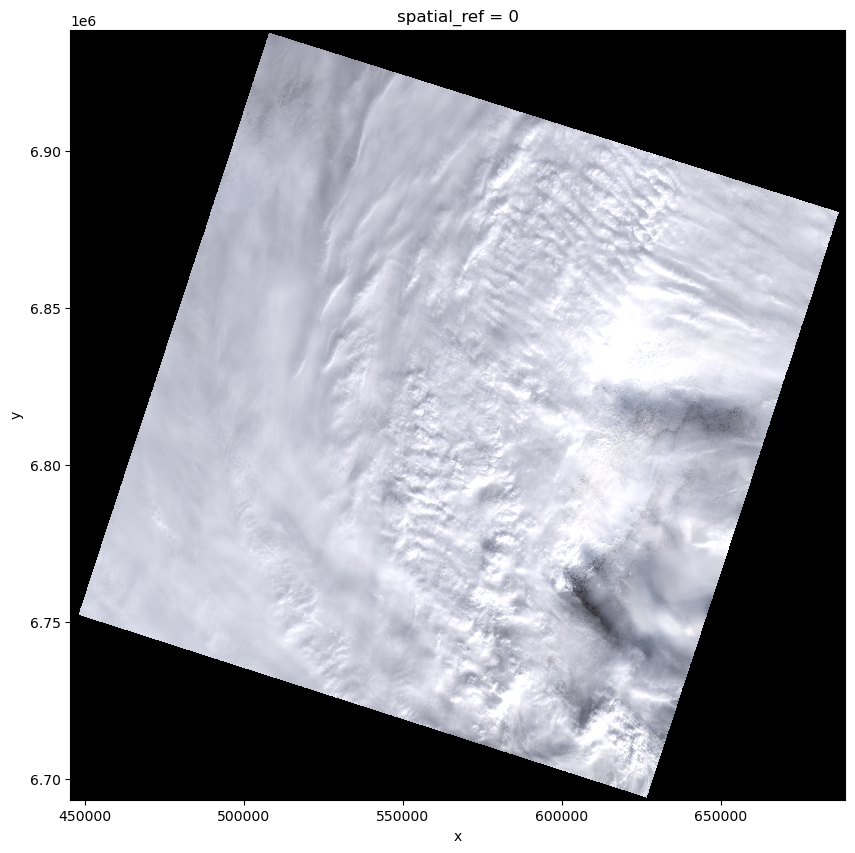

In [20]:
data.plot.imshow(robust=True, figsize=(10, 10))